In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as sdist
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs

sns.set(style="white")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Agglomerative clustering** иерархическая кластеризация методом снизу-вверх, т.е. данные рассматриваются как индивидуальные кластеры и соединяются пока не достигнут одного кластера.

1. Каждая точка является отдельным кластером;
2. Два самых схожих кластеров соединяются в один;
3. Повторить шаг 2 пока не останется один кластер.

In [3]:
def getindices(from_cluster: int, to_cluster: int) -> tuple[int, int]:
    """ Обрабатывает индексы для обращения к матрице

    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: индекс строчки и колонки матрицы для обращения к расстояния между кластерами
    """
    row_index, column_index = (
        from_cluster, to_cluster) if from_cluster > to_cluster else (to_cluster, from_cluster)
    return row_index, column_index

In [4]:
def get_count(linkage_matrix, node, n_samples):
    return linkage_matrix[node - n_samples][-1] if node >= n_samples else 1

In [5]:
def agglomerative_clustering(
    data: np.ndarray, linkage: str = 'average_linkage', metric: str = 'euclidean'
) -> list[np.ndarray]:
    """ Производит иерархическую кластеризацию

    :param data: (n_samples, n_features) данные
    :param linkage: вид связности используемый для подсчета расстояния между кластерами
    :param metric: вид формулы расстояния
    :return: (n_iter, n_samples) история лейблов
    """
    # начинаем с кол-ва кластеров равным размеру выборки
    n_samples = data.shape[0]
    labels = np.arange(n_samples)
    labels_history = [labels.copy()]

    clusters = np.unique(labels)
    linkage_matrix, distances = [], {}

    cluster_id, n_iter = None, 0
    while not np.all(labels == labels[0]):
        distances = calculate_linkage(
            data, labels, distances, linkage, metric, cluster_id)
        from_cluster, to_cluster = min(distances, key=distances.get)

        distance = distances[getindices(from_cluster, to_cluster)]
        count = get_count(linkage_matrix, from_cluster, n_samples) + \
            get_count(linkage_matrix, to_cluster, n_samples)
        linkage_matrix.append([from_cluster, to_cluster, distance, count])

        [distances.pop(getindices(from_cluster, cluster_id), None)
         for cluster_id in clusters]
        [distances.pop(getindices(to_cluster, cluster_id), None)
         for cluster_id in clusters]

        cluster_id = n_samples + n_iter

        clusters = np.delete(clusters, np.argwhere(
            (clusters == from_cluster) | (clusters == to_cluster)))
        clusters = np.append(clusters, cluster_id)

        labels[(labels == from_cluster) | (labels == to_cluster)] = cluster_id
        labels_history.append(labels.copy())

        n_iter += 1

    return labels_history, linkage_matrix

Рандомно инициализируем датасет со значениями кластера

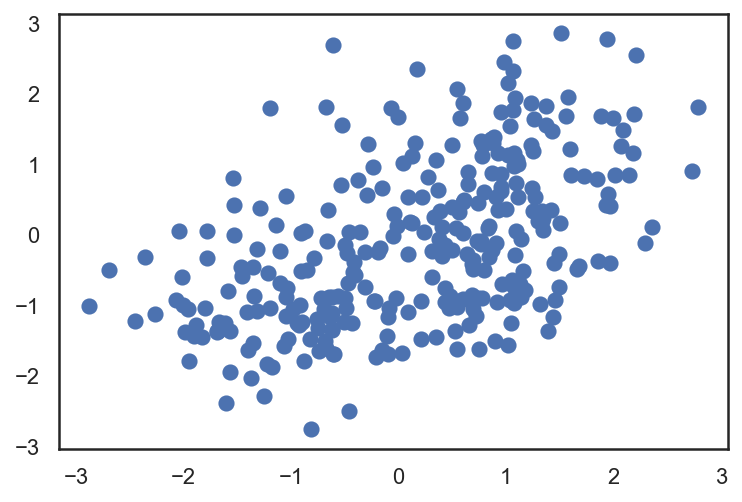

In [6]:
RANDOM_STATE = 8

centers = [[1, 1], [-1, -1], [0.5, -0.5]]
centers = np.reshape(centers, (3, 2))

X, true_labels = make_blobs(
    n_samples=300,
    centers=centers,
    cluster_std=0.7,
    random_state=RANDOM_STATE
)

plt.scatter(X[:, 0], X[:, 1], s=50, c="b")
plt.show()

**Виды связности кластеров**

Можно рассматривать схожесть кластеров с помощью разных алгоритмов, которые влияют на финальный вариант кластеризации.

- **Single linkage**: схожесть кластеров определяется расстоянием между ближайшими точками двух кластеров;
- **Complete linkage**: cхожесть кластеров определяется расстоянием между наименее схожими точками двух кластеров;
- **Centroid linkage**: схожесть кластеров определяется расстоянием между центроидами двух кластеров;
- **Average linkage**: схожесть кластеров определяется средним расстоянием между всеми точками двух кластеров;
- **Ward linkage**: схожесть кластеров определяется суммой инерции, чтобы сохранить гомоногенность кластеров. Используется только с Euclidean и Chi-square функциями расстояний.

In [7]:
def calculate_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    distances: np.ndarray,
    linkage: str,
    metric: str,
    from_cluster: int = None,
) -> np.ndarray:
    """ Подсчет расстояния между кластерами

    Если параметр `from_cluster` не указан, происходит
    первая инициализация матрицы расстояний между кластерами

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param distances: (n_samples, n_samples) матрица расстояний
    :param linkage: вид связности используемый для подсчета расстояния между кластерами
    :param metric: вид формулы расстояния
    :param from_cluster: индекс кластера 
    :return: (n_samples, n_samples) матрица расстояний
    """

    def distance_between_clusters(from_cluster: int, to_cluster: int):
        """ Расстояние между кластерами from_cluster и to_cluster

        :param from_cluster: индекс кластера
        :param to_cluster: индекс кластера
        """
        # используем соответственную функцию связности для подсчета расстояния
        distance = globals()[linkage](data, labels, metric, from_cluster, to_cluster)
        row_index, column_index = getindices(from_cluster, to_cluster)
        distances[(row_index, column_index)] = distance

    # достаем индексы кластеров из лейблов
    clusters = np.unique(labels)
    for to_cluster in clusters:
        if from_cluster is None:
            for cluster_id in clusters[to_cluster + 1 :]:
                distance_between_clusters(cluster_id, to_cluster)
        elif from_cluster != to_cluster:
            distance_between_clusters(from_cluster, to_cluster)

    return distances

In [8]:
def single_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    metric: str,
    from_cluster: int,
    to_cluster: int,
) -> np.float64:
    """ Соединение кластеров с помощью single linkage

    Схожесть кластеров определяется расстоянием между ближайшими
    точками двух кластеров

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param metric: вид формулы расстояния
    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: расстояние
    """
    distance = cdist(data[labels == from_cluster],
                     data[labels == to_cluster],
                     metric=metric)
    return distance.flatten().min()

In [9]:
def complete_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    metric: str,
    from_cluster: int,
    to_cluster: int,
) -> np.float64:
    """ Соединение кластеров с помощью complete linkage

    Схожесть кластеров определяется расстоянием между
    самими дальними точками двух кластеров

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param metric: вид формулы расстояния
    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: расстояние
    """
    distance = cdist(data[labels == from_cluster],
                     data[labels == to_cluster],
                     metric=metric)
    return distance.flatten().max()

In [10]:
def centroid_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    metric: str,
    from_cluster: int,
    to_cluster: int,
) -> np.float64:
    """ Соединение кластеров с помощью centroid linkage

    Схожесть кластеров определяется расстоянием между
    самими центроидами двух кластеров

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param metric: вид формулы расстояния
    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: расстояние
    """
    from_centroid = data[labels == from_cluster].mean(0)
    to_centroid = data[labels == to_cluster].mean(0)

    return getattr(sdist, metric)(from_centroid, to_centroid)

In [11]:
def average_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    metric: str,
    from_cluster: int,
    to_cluster: int,
) -> np.float64:
    """ Соединение кластеров с помощью average linkage

    Схожесть кластеров определяется средним расстоянием
    между каждыми точками двух кластеров

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param metric: вид формулы расстояния
    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: расстояние
    """
    distance = cdist(data[labels == from_cluster],
                     data[labels == to_cluster],
                     metric=metric)
    return distance.flatten().mean()

In [12]:
def ward_linkage(
    data: np.ndarray,
    labels: np.ndarray,
    metric: str,
    from_cluster: int,
    to_cluster: int,
) -> np.float64:
    """ Соединение кластеров с помощью ward linkage

    Схожесть кластеров определяется инерции при объединении
    этих кластеров

    :param data: (n_samples, n_features) данные
    :param labels: (n_samples) лейблы данных по кластерам
    :param metric: (не используется) вид формулы расстояния
    :param from_cluster: индекс кластера
    :param to_cluster: индекс кластера
    :return: инерция
    """
    centroid = data[(labels == from_cluster) | (labels == to_cluster)]
    distances = cdist(data[(labels == from_cluster) |
                      (labels == to_cluster)], centroid)
    return distances.flatten().sum()

Рассмотрим использования разных видов сходимости кластеров. Графики отрисованы с разным количеством кластеров.

In [13]:
def plot_resulted_clusters(
    data: np.ndarray,
    labels_history: list[np.ndarray],
    n_clusters: int,
    n_row_plots: int,
    n_column_plots: int,
    n_plot: int,
    linkage: str,
    metric: str = None
):
    """ Отрисовка данных с разным кол-вом кластеров

    :param data: (n_samples, n_features) данные
    :param labels_history: (n_iter, n_samples) история лейблов
    :param n_clusters: число кластеров для отрисовки
    :param n_row_plots: количество графиков в строке
    :param n_column_plots: количество графиков в колонке
    :param n_plot: номер графика
    :param linkage: название связности
    :param metric: название метрики для расстояния
    """
    labels = labels_history[-n_clusters].copy()
    for n_cluster in range(n_clusters):
        labels[labels == max(labels)] = n_cluster
    
    plt.subplot(n_row_plots, n_column_plots, n_plot)
    plt.scatter(data[:, 0], data[:, 1],
                c=labels, s=50, cmap='viridis')
    plt.title(f'Результат кластеризации | {n_clusters} кластера\n{linkage} | {metric}')

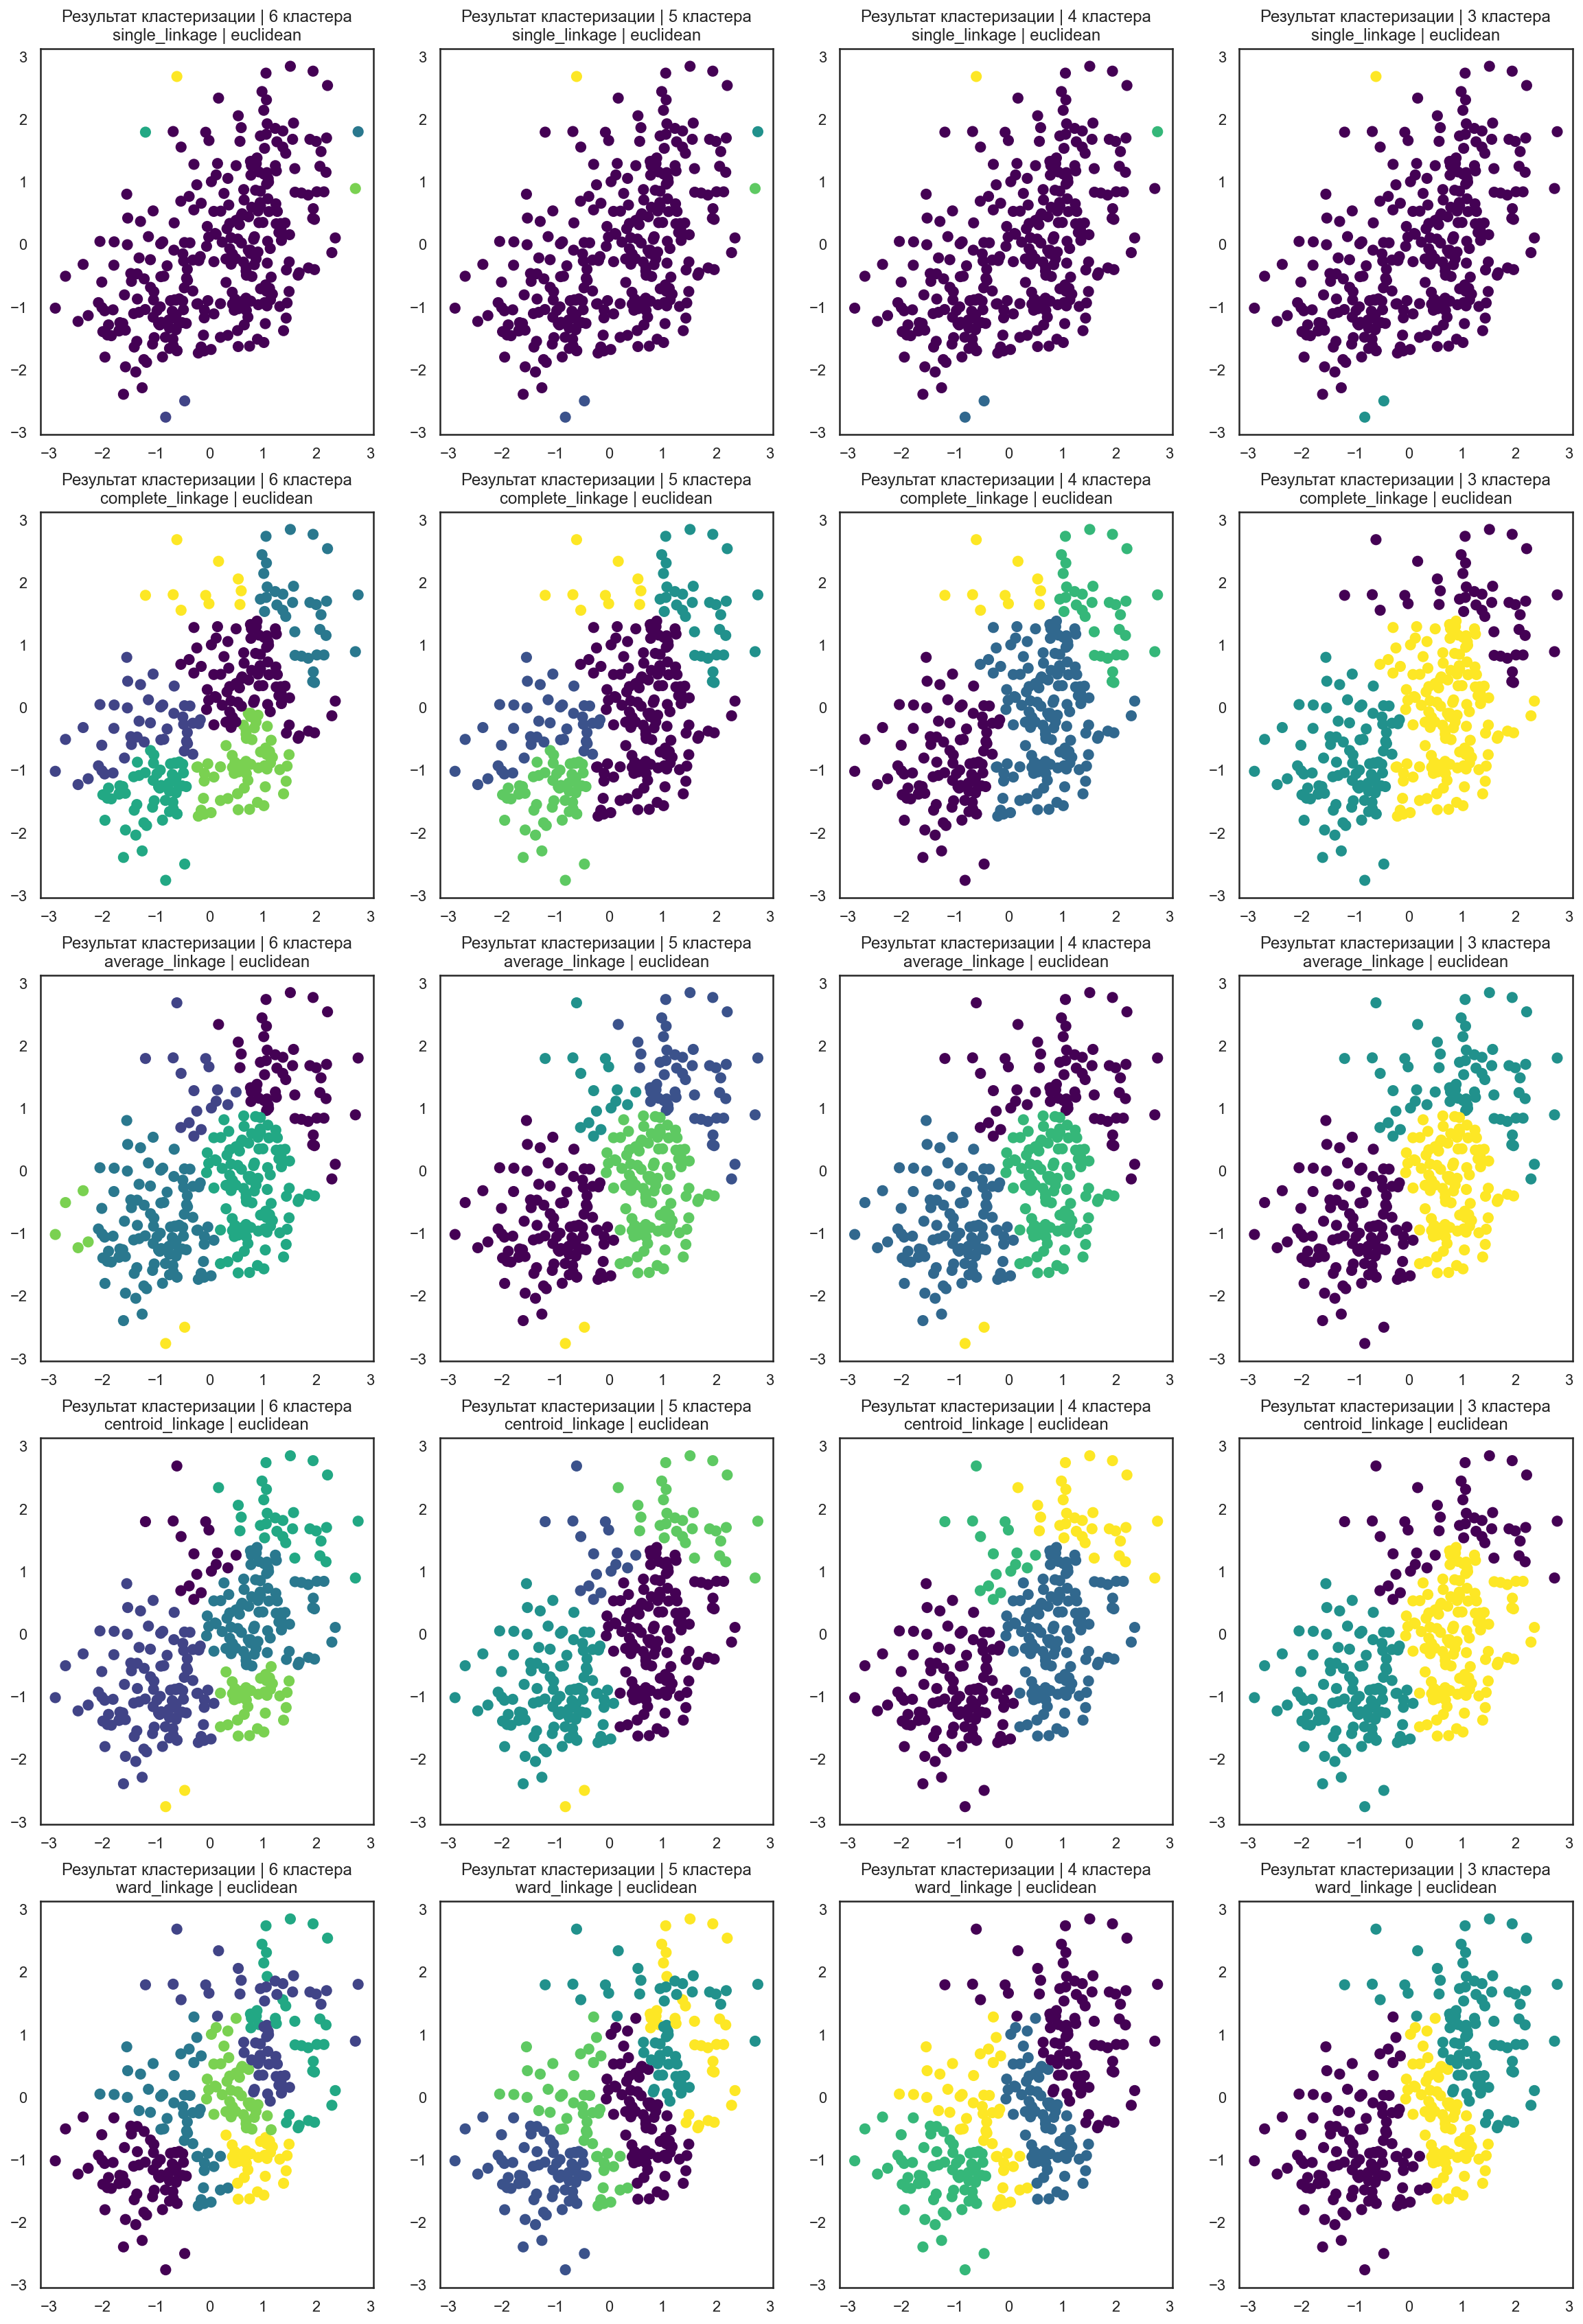

In [14]:
linkages = ['single_linkage', 'complete_linkage',
            'average_linkage', 'centroid_linkage', 'ward_linkage']
n_clusters_plot = [6, 5, 4, 3]

n_row_plots, n_column_plots = len(linkages), len(n_clusters_plot)
plt.figure(figsize=(n_column_plots * 5, n_row_plots * 6))

for n_row, linkage in enumerate(linkages):
    results, linkage_matrix = agglomerative_clustering(X, linkage=linkage)
    for n_column, n_clusters in enumerate(n_clusters_plot):
        n_plot = n_column_plots * n_row + n_column + 1
        plot_resulted_clusters(X, results, n_clusters=n_clusters, n_row_plots=n_row_plots,
                               n_column_plots=n_column_plots, n_plot=n_plot, linkage=linkage, metric='euclidean')

Agglomerative clustering работает по принципу "богатый становится богаче", что может приводить к неравномерному размеру кластеров. Single linkage, в таком случае, худшая стратегия, когда ward linkage выдаст более менее равные размеры кластеров. Однако у ward linkage есть недостаток в том, что ему приходится использовать метрики расстояния с квадратом. Для неевклидовых метрик хорошей альтернативой будет average linkage.

Так же можно использовать разные метрики для подсчета **расстояния**.

- Euclidean: $$d(x, y) = \sqrt{\sum_{i=1}^n{(y_i - x_i)^2}}$$
- Cosine: $$d(x, y) = 1 - \frac{x y}{\|x\| \|y\|}$$
- Canberra: $$d(x, y) = \sum_{i=1}^n \frac{|x_i - y_i|}{|x_i| + |y_i|}$$
- Chebyshev: $$d(x, y) = \max_i |x_i - y_i|$$

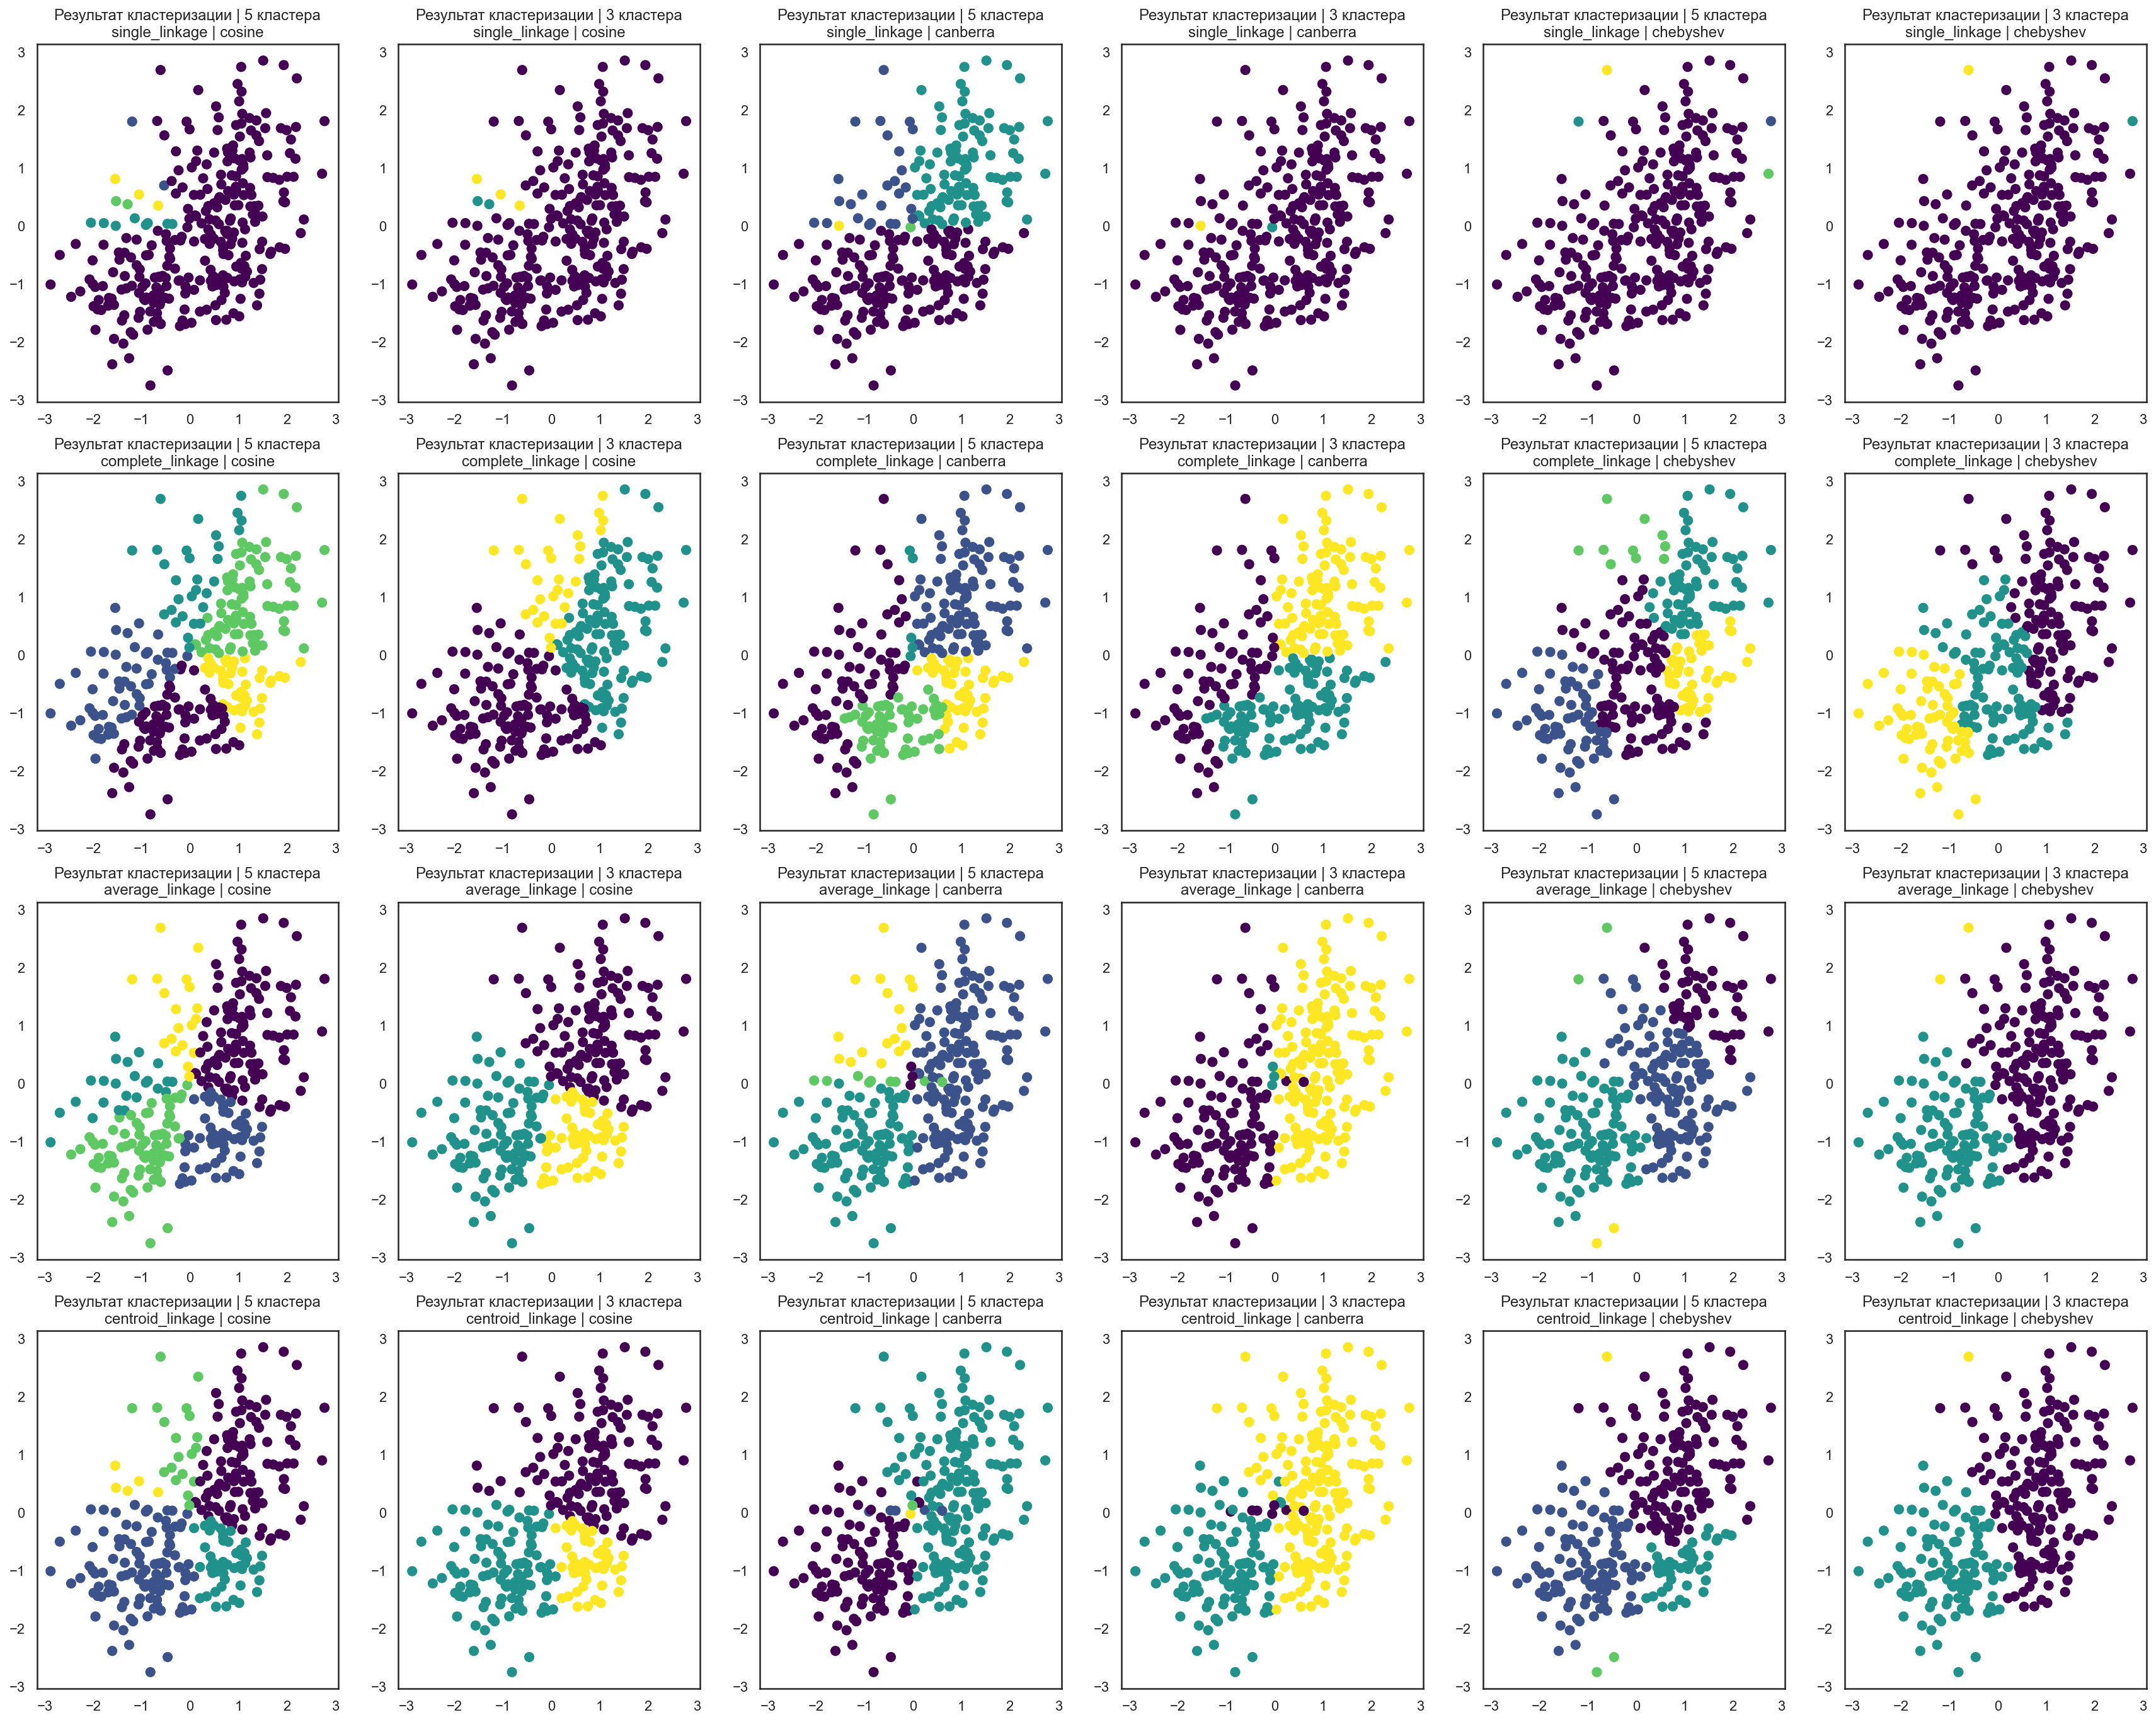

In [15]:
linkages = ['single_linkage', 'complete_linkage',
            'average_linkage', 'centroid_linkage']
metrics = ['cosine', 'canberra', 'chebyshev']
n_clusters_plot = [5, 3]

n_row_plots, n_column_plots = len(linkages), len(metrics) * len(n_clusters_plot) 
plt.figure(figsize=(n_column_plots * 5, n_row_plots * 6))

for n_row, linkage in enumerate(linkages):
    for n_column_mul, metric in enumerate(metrics):
        results, linkage_matrix = agglomerative_clustering(X, linkage=linkage, metric=metric)
        for n_column, n_clusters in enumerate(n_clusters_plot):
            n_plot = n_column_plots * n_row + len(n_clusters_plot) * n_column_mul + n_column + 1
            plot_resulted_clusters(X, results, n_clusters=n_clusters, n_row_plots=n_row_plots,
                                   n_column_plots=n_column_plots, n_plot=n_plot, linkage=linkage, metric=metric)

Результат алгоритма можно визуализировать с помощью дендограмы.

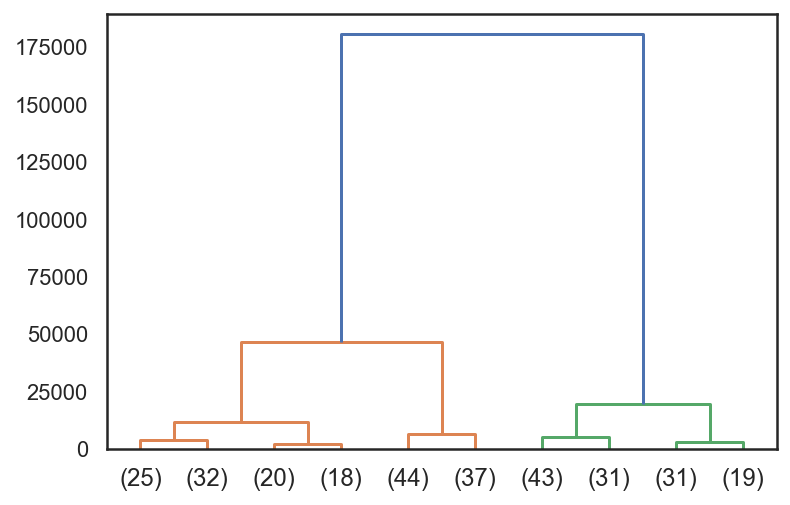

In [16]:
results, linkage_matrix = agglomerative_clustering(X, linkage='ward_linkage')
dn = dendrogram(linkage_matrix, p=10, truncate_mode='lastp')

Алгоритм не просит указывать количество кластеров заранее. Но в результате все равно нужно получить оптимальное разделение на кластеры.

- можно использовать дендограму, разрезая ее, где расстояние наибольшее между объединениями;
- можно останавливать алгоритм при определенном максимальном расстоянии, после которого кластеры не объединяются: параметр `distance_threshold` в [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering);
- можно так же указать количество кластеров: параметр `n_clusters` в [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering).

[]

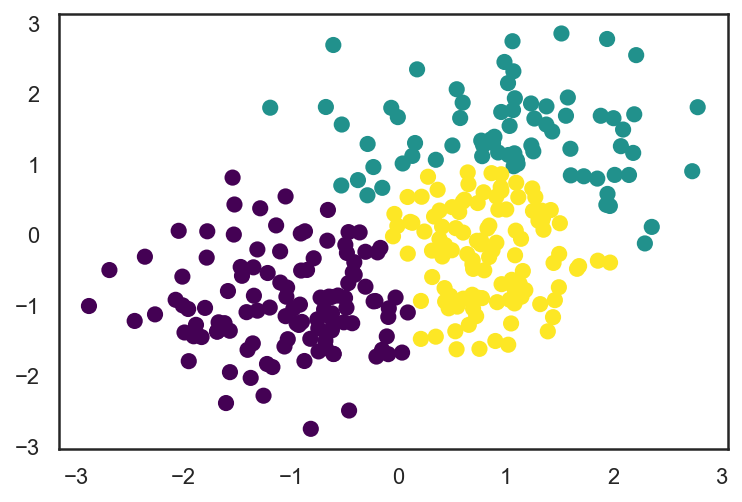

In [17]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)

plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, s=50, cmap='viridis')
plt.plot()

**Итог**

| Параметры | Плюсы | Минусы |
| :-------- | :---- | :----- |
| - `n_clusters`: число кластеров;<br> - `distance_threshold`: порог расстояния;<br> - `linkage`: тип связности;<br> - `affinity`: тип метрики расстояния. | - необязательно указывать число кластеров изначально;<br> - алгоритм возвращает разные результаты кластеризации на разном уровне. | - занимает много памяти и времени на больших данных.